$$\require{mhchem}$$
# Transport Problem: Advection + Diffusion, Dispersion


$\frac{\partial c}{\partial t}_x = -v\left(\frac{\partial c}{\partial x} \right)$

## Finite-Differences Solution

Advection step:

$\Delta t = v*\Delta x$

Thus:

${c_x}^{t2} = {c_{x-1}}^{t1}$

We need to correct for Numerical dispersion if retardation occurs.

${c_x}^{t2} + {q_x}^{t2} = {c_{x-1}}^{t1} + {q_x}^{t1} + (1-\omega)*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t1}-2 {c_{x}}^{t1}+{c_{x+1}}^{t1}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t1} +(1-2\alpha) {c_{x1}}^{t1} + \alpha {c_{x+1}}^{t1}\right)\right]+  
\omega*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t2}-2 {c_{x}}^{t2}+{c_{x+1}}^{t2}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t2} +(1-2\alpha) {c_{x1}}^{t2} + \alpha {c_{x+1}}^{t2}\right)\right]$

## Model

#### libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import aesara
import aesara.tensor as at

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defining problem as a coupled ODE system:

We define the coupled ODE system by assuming the discretization remains and writing the solution as a system of partial derivatives (ODE system) solved unsing a numerical solver.

In [2]:
def f(t,y,deltax,
      D,
      alpha_l,
      v,
      c_in):
    
    mixf = (D + v*alpha_l)/deltax**2
    
    r = np.zeros(y.shape[0])
    
    
    r[0] = -v*(y[0]-c_in)/(deltax/2) + (-mixf)*y[0] + mixf*y[1]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(y, (3))
    kernel = np.array([mixf, -2*mixf, mixf])
    r[1:-1] = np.dot(sliding_window,kernel)
    #Update the last cell:
    r[-1] = mixf*y[-1-1] + (-mixf)*y[-1]
    r[1:-1] = r[1:-1]-v*(np.roll(y,-1)[1:-1]-np.roll(y,1)[1:-1])/(2*deltax)
    r[-1] = r[-1]-v*(y[-1]-y[-2])/deltax
    return r
    


ode_system(0,ode_system(5,ode_system(5,y0,deltax,De,alpha_l,v,c_in),deltax,De,alpha_l,v,c_in),deltax,De,alpha_l,v,c_in)

#### Running Problem:

Model the linear retardation of y-HCH in a 5 cm long and 5 cm diameter lab column with a sandy aquifer sample.

#### input

In [3]:
organic_carbon_aquifer = 0.05 #%
porosity = 0.3
alpha_l = 1e-3 #dispersivity [dm]
injected_volume = 450 #ml
flow_rate = 10*1e-5/3600 #l/hr
De = 1e-9
Kd = 6
c_in = 20 #microg/L

In [4]:
c0 = 0
q0 = 0
v = flow_rate/(np.pi*2.5**2*1e-2)/porosity
pore_volume = (np.pi*2.5**2)*5*1e-3
totx = 0.5 #dm
R = 1
max_time = 700*3600

In [5]:
v

4.7157020175376405e-07

### Coupled ODESolver approach

This process is not mature yet, however we can get an accurate result with a very large number of cells.

In [6]:
mixf = (alpha_l*v+De)
#Max x size (Peclet number = 0.1)
max_deltax = 1*mixf/v
x_steps_min = totx/max_deltax
x_steps_min = np.ceil(x_steps_min)
print(x_steps_min)

ncells = int(x_steps_min)
deltax = totx/ncells
y0 = np.repeat(0,ncells)
y0

161.0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [7]:
max_time

2520000

In [8]:
mixf = (De + v*alpha_l)/deltax**2


In [9]:
timesteps = np.arange(0,max_time,60)

In [10]:
timesteps

array([      0,      60,     120, ..., 2519820, 2519880, 2519940])

## Aesara Tensor formulation

In [11]:
from aesara.tensor.subtensor import set_subtensor

In [12]:
velo_ = at.dscalar('velo')
c_in_ = at.dscalar('c_in')
deltax_ = at.dscalar('dx')
mixf_ = at.dscalar('mixf')

y_ = at.dvector('y')
y_ = at.specify_shape(y_, (ncells))


r = at.zeros_like(y_, dtype = 'float64')

r = set_subtensor(r[0], -velo_*(y_[0]-c_in_)*2/deltax_ +mixf_*y_[0] + mixf_*y_[1])

for i in range(1,ncells-1):
    r = set_subtensor(r[i], mixf_*y_[i-1] - 2*mixf_*y_[i] + mixf_*y_[i+1] + (-velo_)*(y_[i+1] - y_[i-1])/(2*deltax_))

r_last = mixf_*y_[-2] - mixf_*y_[-1] -velo_*(y_[-1] - y_[-2])/deltax_
r = set_subtensor(r[-1], r_last)

f = aesara.function([y_,velo_,c_in_,deltax_,mixf_], r)



In [13]:
f(f(f(y0,v,c_in,deltax,mixf),v,c_in,deltax,mixf),v,c_in,deltax,mixf)

array([6.07290672e-03, 1.38724219e-06, 3.17131046e-10, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [14]:
jac = aesara.gradient.jacobian(r, [y_])

In [15]:
jac[0].eval({y_: y0, velo_: v, deltax_: deltax, c_in_: c_in, mixf_: mixf})

array([[-1.51112925e-04,  1.52578285e-04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.28501087e-04, -3.05156570e-04,  7.66554823e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.28501087e-04, -3.05156570e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.05156570e-04,  7.66554823e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.28501087e-04, -3.05156570e-04,  7.66554823e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.04423890e-04, -3.04423890e-04]])

In [16]:
def ode_system(t,y,deltax,D,alpha_l,v,c_in):
    mixf = (D+alpha_l*v)/deltax**2
    return f(y,v,c_in,deltax,mixf)

def jac_fun(t,y,deltax,D,alpha_l,v,c_in):
    mixf = (D+alpha_l*v)/deltax**2
    return jac[0].eval({y_: y, velo_: v, deltax_: deltax, c_in_: c_in, mixf_: mixf})

In [17]:
c_ode = scipy.integrate.solve_ivp(ode_system,[0,max_time],y0,t_eval = timesteps,args = (deltax,De,alpha_l,v,c_in), 
                              tfirst = True, atol = 1e-12, rtol = 1e-11)

C:\Users\Vitor Cantarella\miniconda3\envs\nitrogene-env\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `tfirst`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [18]:
c_ode

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 10136
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([      0,      60,     120, ..., 2519820, 2519880, 2519940])
 t_events: None
        y: array([[0.00000000e+00, 3.62789888e-01, 7.22350157e-01, ...,
        2.22699954e+04, 2.22711581e+04, 2.22723208e+04],
       [0.00000000e+00, 2.47553874e-03, 9.81287054e-03, ...,
        2.21433041e+04, 2.21444612e+04, 2.21456183e+04],
       [0.00000000e+00, 1.12872734e-05, 8.92776158e-05, ...,
        2.20172205e+04, 2.20183720e+04, 2.20195235e+04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.21801788e+03, 8.21856204e+03, 8.21910621e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.16855750e+03, 8.16909947e+03, 8.16964147e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.13895726e+03, 8.13949793e+03, 8.14003863e+03]])
 y_e

In [19]:
c_ode_j = scipy.integrate.odeint(ode_system,y0,timesteps,args = (deltax,De,alpha_l,v,c_in), 
                              Dfun = jac_fun, 
                              tfirst = True,
                              atol = 1e-11, rtol = 1e-11)

In [20]:
cumulated_volume = flow_rate*timesteps

### Analytical solution:

In [21]:
def analytical(t,c_in,L,v,Dl,R):
    c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(v*L/Dl)*
                  scipy.special.erfc((L+v*t/R)/np.sqrt(4*Dl*t/R)))
    return c

In [22]:
c_out_ana = np.zeros(timesteps.shape)
Dl = De+v*alpha_l
for i in range(timesteps.shape[0]):
    c_out_ana[i] = analytical(timesteps[i],c_in,totx,v,Dl,R) 
    

C:\Users\Vitor Cantarella\AppData\Local\Temp\ipykernel_21052\707810831.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(v*L/Dl)*
C:\Users\Vitor Cantarella\AppData\Local\Temp\ipykernel_21052\707810831.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  scipy.special.erfc((L+v*t/R)/np.sqrt(4*Dl*t/R)))


In [23]:
analytical(timesteps[3],c_in,totx,v,Dl,R) 

0.0

In [24]:
pore_flushes = cumulated_volume/pore_volume
#pore_flushes[::7]

#### Plotting and comparing solutions:

Text(0, 0.5, '[y-HCH] [$\\mu g/L$]')

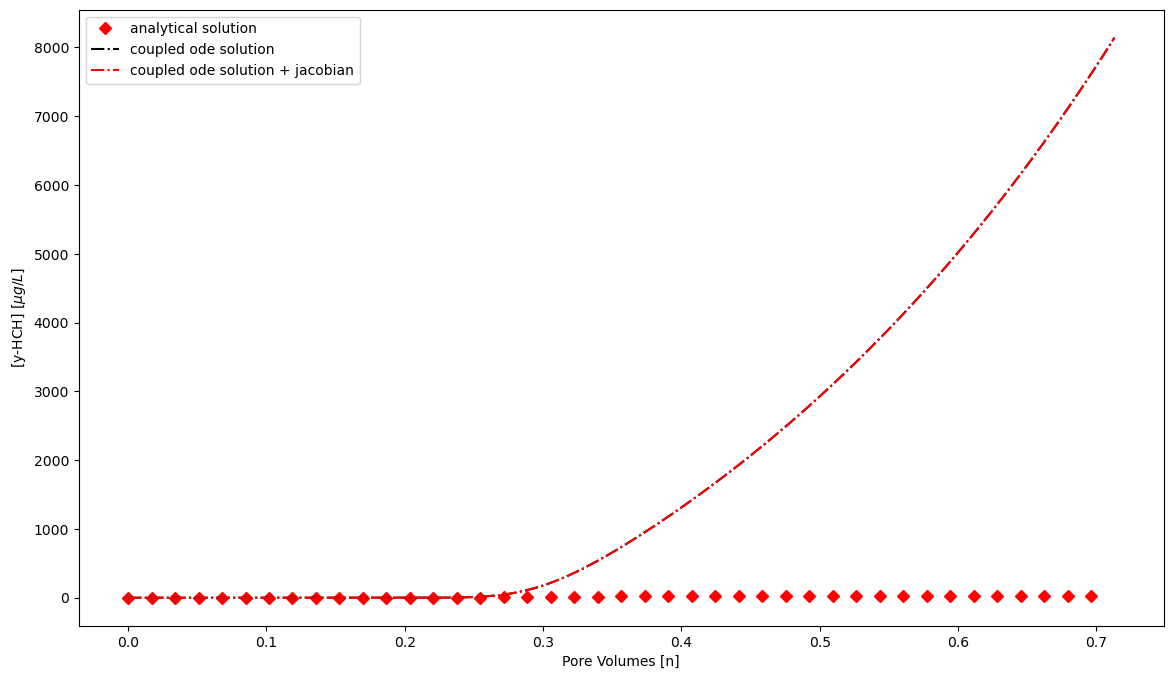

In [25]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)
ax.plot(pore_flushes[::1000],c_out_ana[::1000], 'Dr', label = 'analytical solution')
#ax.plot(pore_flushes,c_outflow,'--k', label = 'O-S numerical solution')
ax.plot(pore_flushes,c_ode.y[-1,:], '-.k', label = 'coupled ode solution')
ax.plot(pore_flushes,c_ode_j[:,-1], '-.r', label = 'coupled ode solution + jacobian')

#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('Pore Volumes [n]')
ax.set_ylabel(r'[y-HCH] [$\mu g/L$]')